# **Ujian Akhir Semester Visi Komputer**

Nama : Fachriza Dian Adhiatma
<br>
NIM  : 18051204061
<br>
Judul : Image generation menggunakan Generative Adversarial Network

# Import libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

# Simpan ukuran batch dan dimensi latent

proses pelatihan model GAN dilakukan dalam batch, oleh karena itu perlu didefinisikan terlebih dahulu ukuran batch yang akan digunakan. Generator akan menghasilkan gambar dengan angka-angka random yang berukuran tertentu, nilai ukuran ini disimpan dalam variabel letent_dim

In [ ]:
latent_dim = 100
batch_size = 32

# Fungsi untuk load dataset dan preprocessing

dataset yang digunakan disini adalah fashion MNIST yang mana dapat di import langsung dari library keras. Data yang telah di load kemudian di normalisasikan sehingga pixel nya mempunyai range 0 dan 1

In [ ]:
def load_dataset():
    (X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train = X_train / 255.0
    X_train = np.float32(X_train)
    
    return X_train, y_train

# Model discriminator

arsitektur discriminator yang dibuat disini adalah sebuah binary classifier CNN. terdiri dari dua buah layer kovolusi yang bertugas untuk downsampling gambar menjadi setengah ukuran aslinya, di sela-sela layer konvolusi terdapat dropout yang berfungsi sebegai regularisasi. layer akhir adalah dense dengan satu neuron yang berfungsi sebagai binary classifier

In [ ]:
def define_discriminator():
    model = keras.models.Sequential([
                # downsample to 14x14
                keras.layers.Conv2D(filters=64, kernel_size=5, strides=2, padding='same', activation='relu', input_shape=[28,28,1]),
                keras.layers.Dropout(0.4),
                # downsample to 7x7
                keras.layers.Conv2D(filters=128, kernel_size=5, strides=2, padding='same', activation='relu'),
                keras.layers.Dropout(0.4),
                # classifier
                keras.layers.Flatten(),
                keras.layers.Dense(units=1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model

In [ ]:
discriminator = define_discriminator()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 1)                 6273      
                                                                 
Total params: 212,865
Trainable params: 212,865
Non-trai

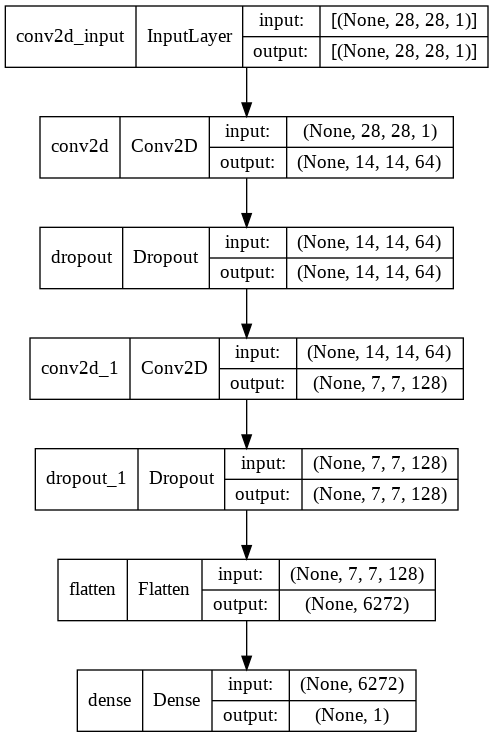

In [ ]:
tf.keras.utils.plot_model(discriminator, show_shapes=True)

# Model generator

jika discriminator melakukan downsampling sampai ukuran terkecil, maka generator akan melakukan upsampling dari ukuran terkecil itu sampai ukuran aslinya. hal tersebut dapat dilakukan dengan menggunakan layer konvolusi transpose. generator akan menerima input berupa angka random dengan ukuran sebesar variabel dimensi latent dan outputnya berupa gambar dengan ukuran 28x28

In [ ]:
def define_generator(latent_dim):
    model = keras.models.Sequential([
            keras.layers.Dense(units=7 * 7 * 128, input_shape=[latent_dim]),
            keras.layers.Reshape([7, 7, 128]),
            keras.layers.BatchNormalization(),
            # upsample to 14x14
            keras.layers.Conv2DTranspose(filters=64, kernel_size=5, strides=2, activation='relu', padding='same'),
            keras.layers.BatchNormalization(),
            # upsample to 28x28
            keras.layers.Conv2DTranspose(filters=1, kernel_size=5, strides=2, activation='relu', padding='same'),
    ])

    return model

In [ ]:
generator = define_generator(latent_dim)
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       204864    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                      

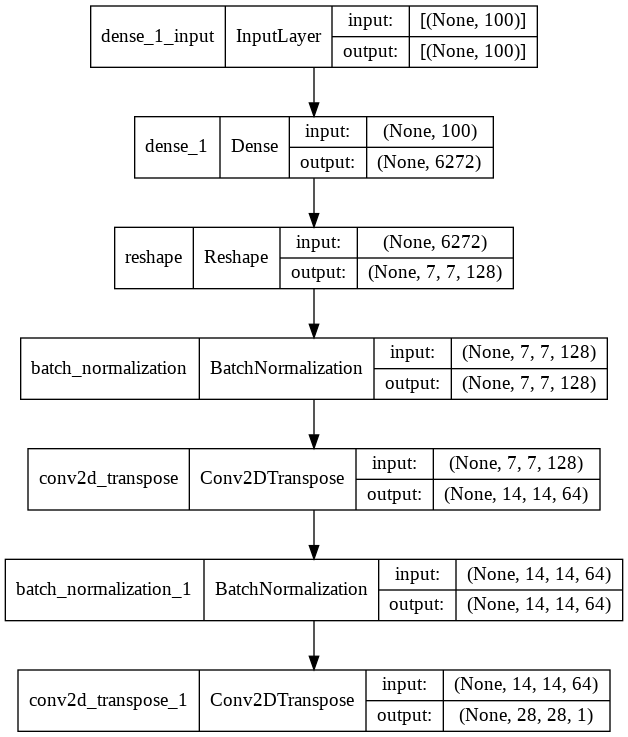

In [ ]:
tf.keras.utils.plot_model(generator, show_shapes=True)

# Model GAN

GAN dapat dibuat dengan menggabungkan model discriminator dan generator secara berurutan dalam model sequential

In [ ]:
def define_gan(generator_model, discriminator_model):
    discriminator.trainable = False
    model = keras.models.Sequential([generator_model, discriminator_model])
    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model

In [ ]:
gan = define_gan(generator, discriminator)
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 28, 28, 1)         840705    
                                                                 
 sequential (Sequential)     (None, 1)                 212865    
                                                                 
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


# Fungsi untuk ploting banyak gambar

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

# Load data dan preprocessing

fungsi load dataset akan melakukan load dataset fashion MNIST dan melakukan normalisasi pada setiap pixel

In [ ]:
X_train, y_train = load_dataset()

4431872/4422102 [==============================] - 0s 0us/step


mengubah format dataset kedalam bentuk batch

In [ ]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1)

dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True)

# Training GAN

Tahap 1 : melatih discriminator
* generate angka-angka random sebanyak ukuran batch dan latent_dim
* generate gambar palsu dari angka random tersebut dan beri label 0
* ambil gambar asli dari dataset dan beri label 1
* train discriminator

Tahap 2 : melatih generator
* generate angka-angka random sebanyak ukuran batch dan latent_dim
* generate gambar palsu dari angka random tersebut dan beri label 1
* freeze discriminator
* train generator via model GAN

In [ ]:
def train(gan_model, dataset, batch_size, latent_dim=100, epochs=100):
    generator, discriminator = gan.layers

    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch + 1, epochs))

        for X_batch in dataset:
            # FASE 1 : training discriminator
            # generate gambar fake
            latent_points = tf.random.normal(shape=(batch_size, latent_dim))
            fake_images = generator(latent_points)
            X_fake_and_real = tf.concat([fake_images, X_batch], axis=0)
            # generate label 0 untuk gambar fake dan 1 untuk gambar real
            y_fake_and_real = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            # train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y_fake_and_real)
            
            # FASE 2 : training generator
            latent_points = tf.random.normal(shape=(batch_size, latent_dim))
            y_real = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(latent_points, y_real)

        plot_multiple_images(fake_images, 8)
        plt.show()

Epoch 1/50


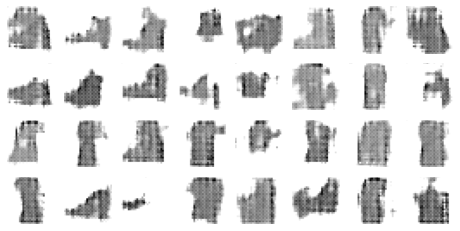

Epoch 2/50


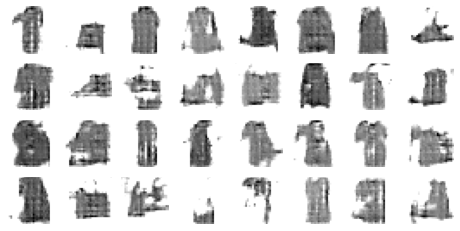

Epoch 3/50


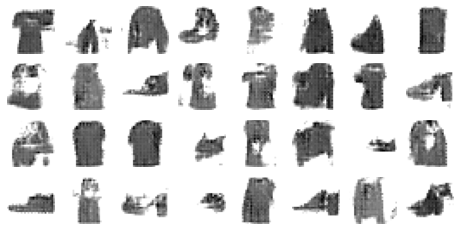

Epoch 4/50


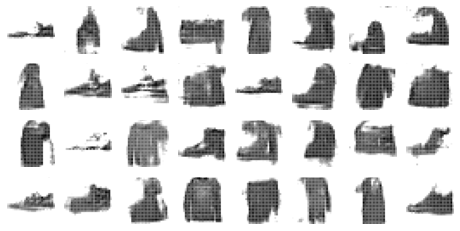

Epoch 5/50


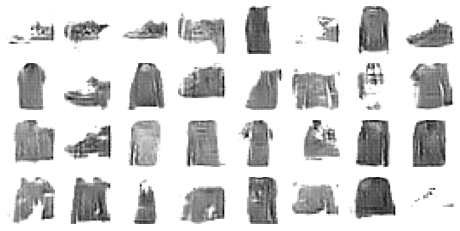

Epoch 6/50


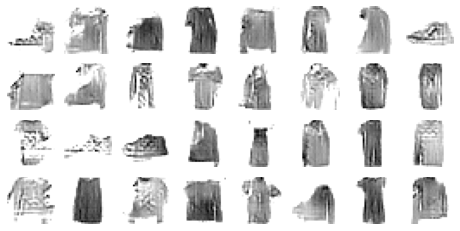

Epoch 7/50


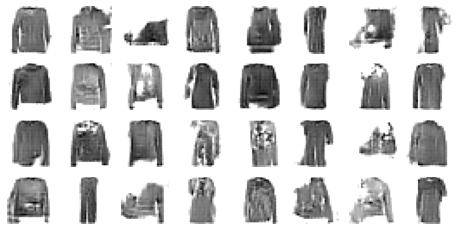

Epoch 8/50


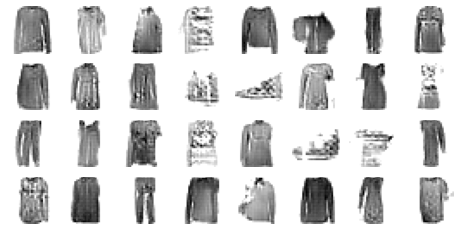

Epoch 9/50


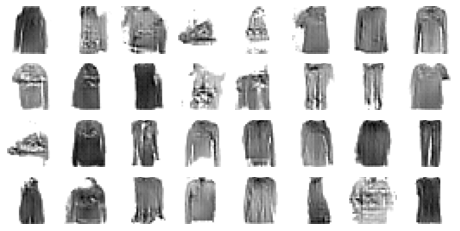

Epoch 10/50


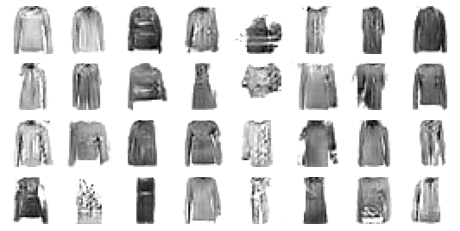

Epoch 11/50


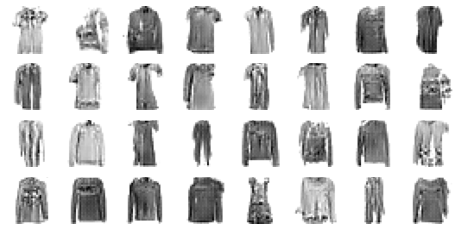

Epoch 12/50


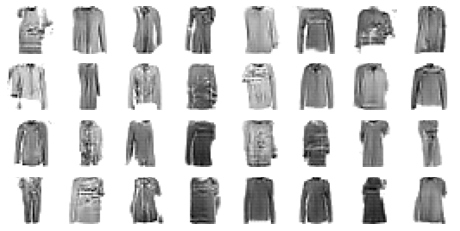

Epoch 13/50


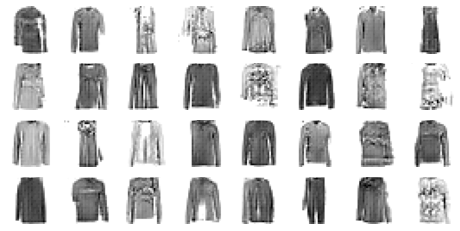

Epoch 14/50


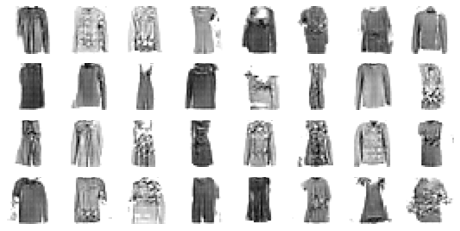

Epoch 15/50


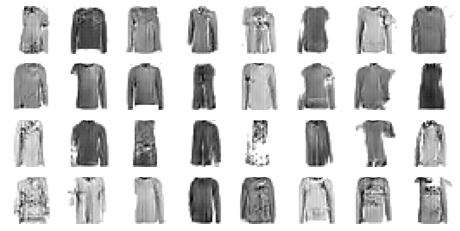

Epoch 16/50


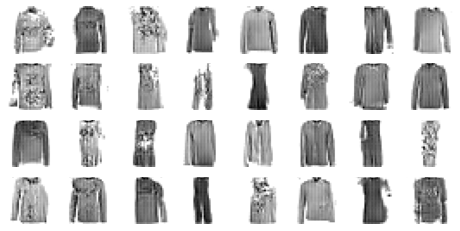

Epoch 17/50


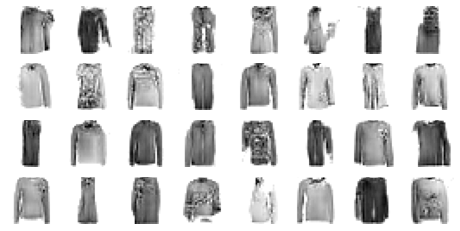

Epoch 18/50


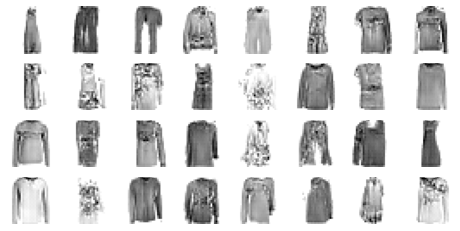

Epoch 19/50


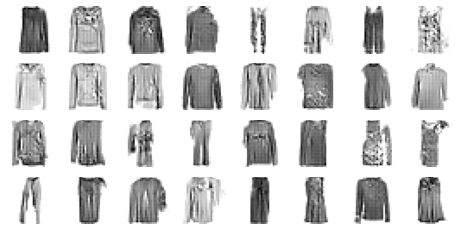

Epoch 20/50


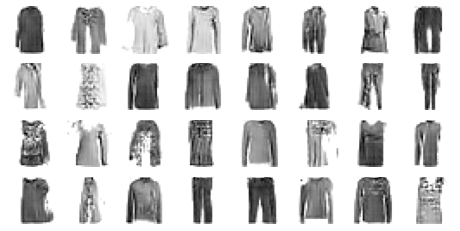

Epoch 21/50


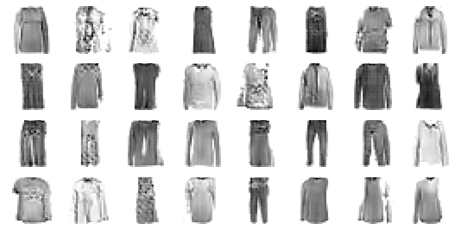

Epoch 22/50


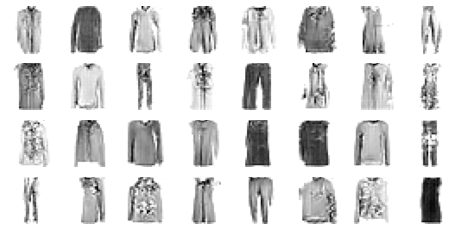

Epoch 23/50


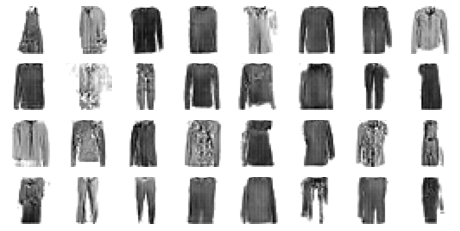

Epoch 24/50


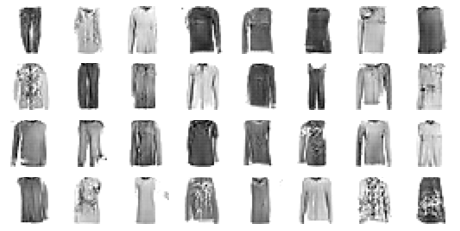

Epoch 25/50


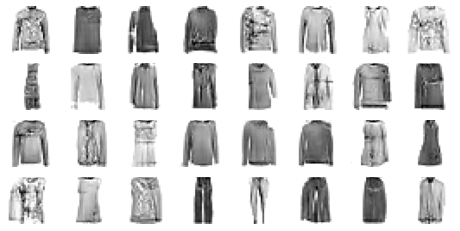

Epoch 26/50


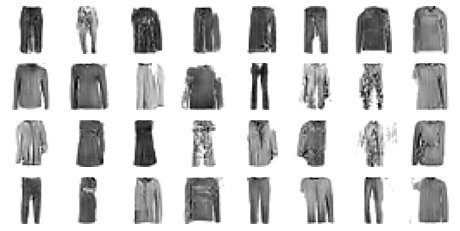

Epoch 27/50


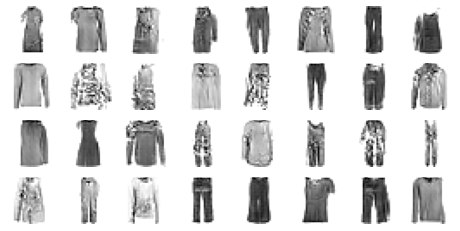

Epoch 28/50


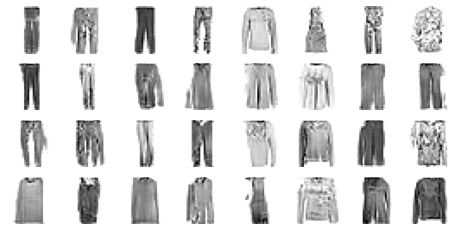

Epoch 29/50


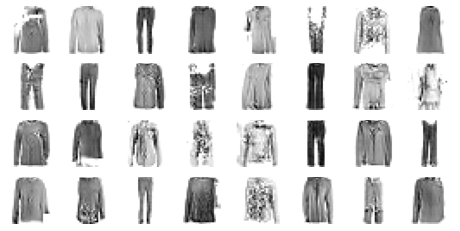

Epoch 30/50


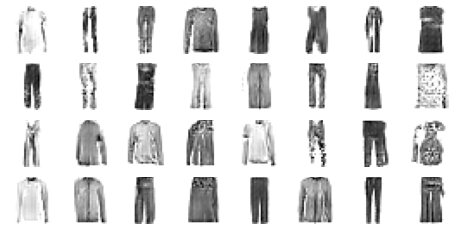

Epoch 31/50


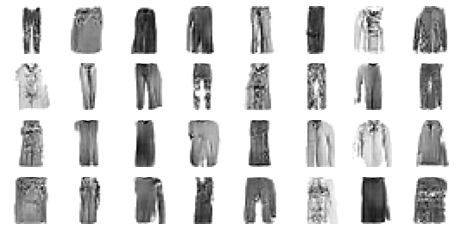

Epoch 32/50


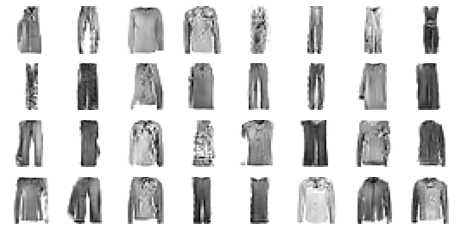

Epoch 33/50


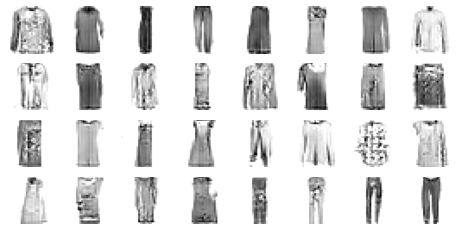

Epoch 34/50


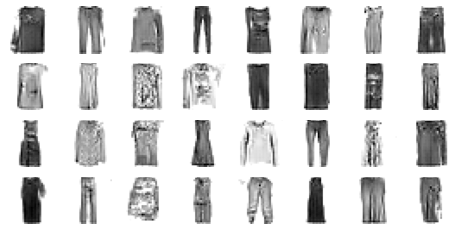

Epoch 35/50


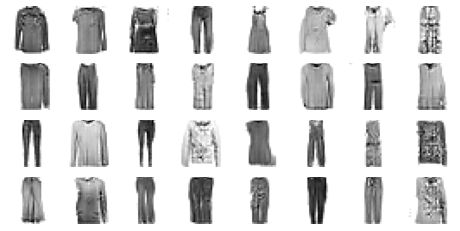

Epoch 36/50


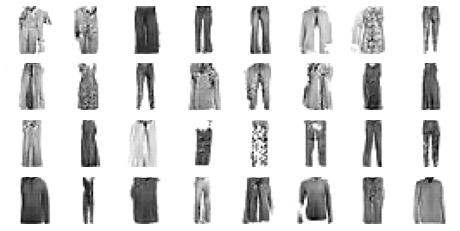

Epoch 37/50


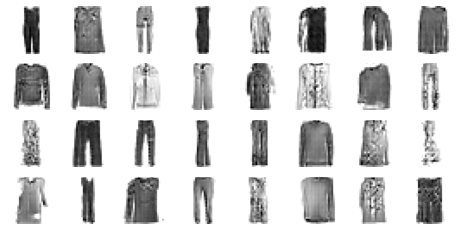

Epoch 38/50


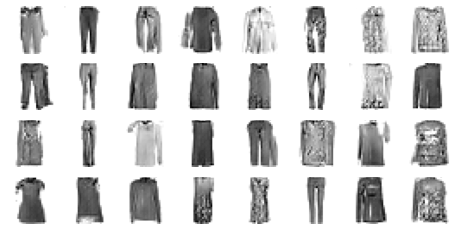

Epoch 39/50


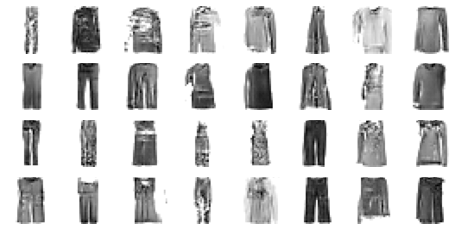

Epoch 40/50


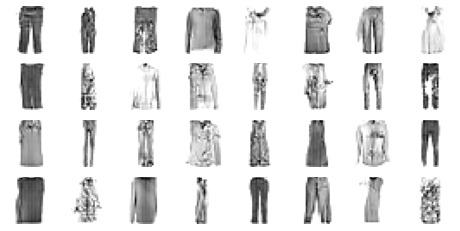

Epoch 41/50


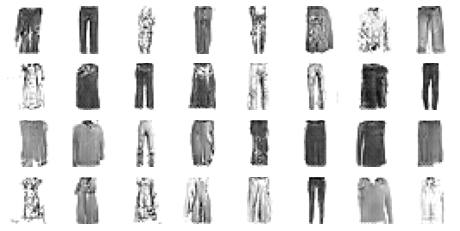

Epoch 42/50


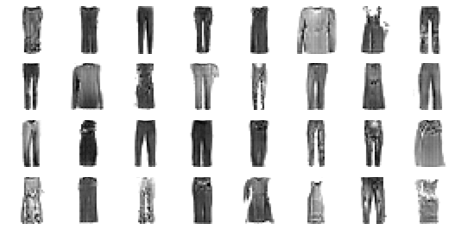

Epoch 43/50


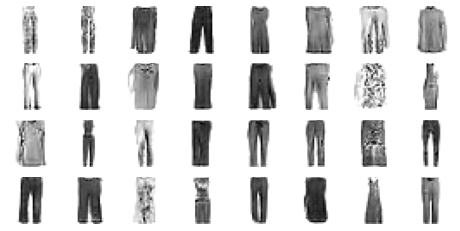

Epoch 44/50


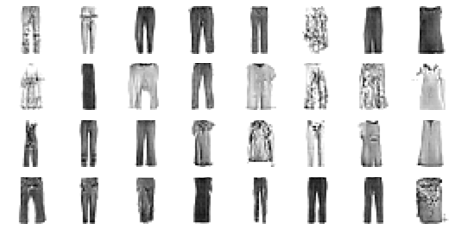

Epoch 45/50


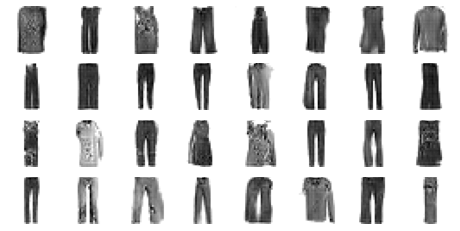

Epoch 46/50


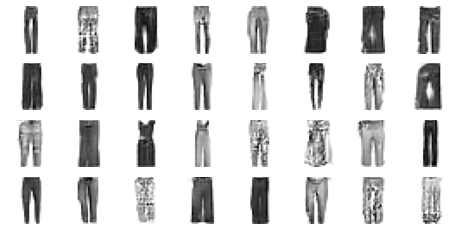

Epoch 47/50


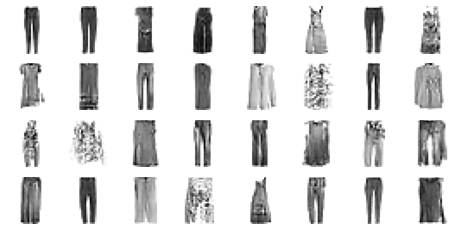

Epoch 48/50


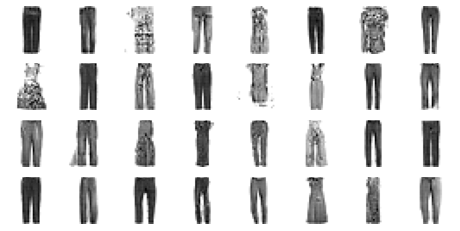

Epoch 49/50


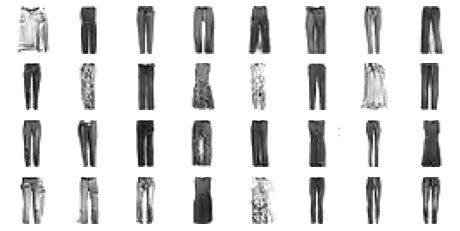

Epoch 50/50


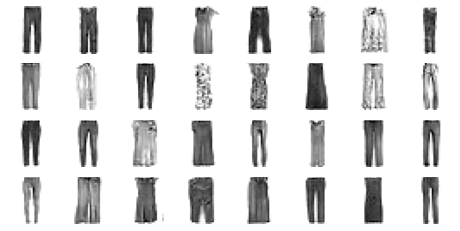

In [ ]:
train(gan, dataset, batch_size, latent_dim, 50)

# Generate gambar baru

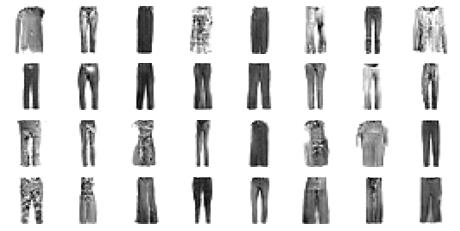

In [ ]:
latent_points = tf.random.normal(shape=(batch_size, latent_dim))
generated_images = generator(latent_points)

plot_multiple_images(generated_images, 8)

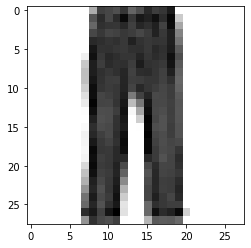

In [ ]:
a = np.squeeze(generated_images[9], axis=-1)

plt.imshow(a, cmap='binary')

# Menyimpan model

In [ ]:
generator.save(r'/content/drive/MyDrive/model/generator-fashion-mnist.h5')

In [ ]:
gan.save(r'/content/drive/MyDrive/model/gan-fashion-mnist.h5')

# Referensi

referensi dari kode ini adalah https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/ . beberapa pengubahan yang dilakukan yaitu arsitektur model generator dan discriminator dan juga fungsi training GAN. Arsitektur model GAN yang dibuat terinspirasi dari buku Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow